## 00: Import modules

In [3]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow.keras.utils as ku 
import numpy as np 

## 01: Prepare Data

In [2]:
# download data
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt \
    -O /tmp/sonnets.txt

# read data
data = open('/tmp/sonnets.txt').read()
corpus = data.lower().split("\n")

# tokenize data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)
total_words = len(tokenizer.word_index) + 1

# create input sequences using list of tokens
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]
	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)


# pad sequences 
max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences, maxlen=max_sequence_len, padding='pre'))

# create predictors and label
predictors, label = input_sequences[:,:-1],input_sequences[:,-1] # the next word is a current sequence's label

label = ku.to_categorical(label, num_classes=total_words) 

--2020-08-13 14:03:21--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sonnets.txt
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.212.128, 172.217.214.128, 74.125.69.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.212.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 93578 (91K) [text/plain]
Saving to: ‘/tmp/sonnets.txt’

/tmp/sonnets.txt    100%[===================>]  91.38K  --.-KB/s    in 0.001s  

2020-08-13 14:03:21 (113 MB/s) - ‘/tmp/sonnets.txt’ saved [93578/93578]



## 02: Build Model

In [7]:
model = Sequential()
model.add(Embedding(total_words,100,input_length=max_sequence_len-1))
model.add(Bidirectional(LSTM(150,return_sequences=True)))
model.add(Dropout(0.2))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(total_words/2,activation='relu',kernel_regularizer=regularizers.l2(0.01)))
model.add(Dense(total_words,activation='softmax'))
# Pick an optimizer
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
print(model.summary())


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 10, 100)           321100    
_________________________________________________________________
bidirectional_2 (Bidirection (None, 10, 300)           301200    
_________________________________________________________________
dropout_1 (Dropout)          (None, 10, 300)           0         
_________________________________________________________________
bidirectional_3 (Bidirection (None, 200)               320800    
_________________________________________________________________
dense_2 (Dense)              (None, 1605)              322605    
_________________________________________________________________
dense_3 (Dense)              (None, 3211)              5156866   
Total params: 6,422,571
Trainable params: 6,422,571
Non-trainable params: 0
____________________________________________

## 03: Training and Visualization

In [8]:
 history = model.fit(predictors, label, epochs=100, verbose=1)

Epoch 1/100
484/484 [==============================] - 43s 89ms/step - loss: 6.9761 - accuracy: 0.0204
Epoch 2/100
484/484 [==============================] - 44s 90ms/step - loss: 6.5056 - accuracy: 0.0225
Epoch 3/100
484/484 [==============================] - 43s 89ms/step - loss: 6.4002 - accuracy: 0.0235
Epoch 4/100
484/484 [==============================] - 44s 90ms/step - loss: 6.2709 - accuracy: 0.0301
Epoch 5/100
484/484 [==============================] - 43s 89ms/step - loss: 6.1755 - accuracy: 0.0365
Epoch 6/100
484/484 [==============================] - 43s 89ms/step - loss: 6.0801 - accuracy: 0.0395
Epoch 7/100
484/484 [==============================] - 43s 89ms/step - loss: 5.9811 - accuracy: 0.0441
Epoch 8/100
484/484 [==============================] - 43s 89ms/step - loss: 5.8758 - accuracy: 0.0471
Epoch 9/100
484/484 [==============================] - 43s 89ms/step - loss: 5.7589 - accuracy: 0.0510
Epoch 10/100
484/484 [==============================] - 43s 89ms/step - l

Let’s have a look at the training process, watching how accuracy and loss change over epochs.

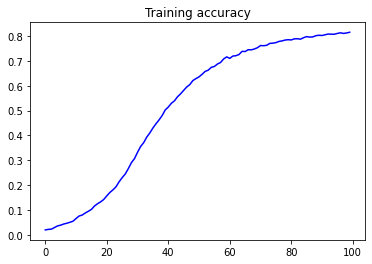

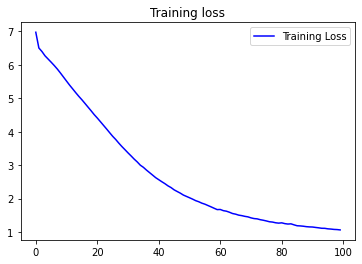

In [11]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
loss = history.history['loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.title('Training accuracy')

plt.figure()

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.title('Training loss')
plt.legend()

plt.show()

## 04: Use the model

Let's use this model to generate a graph with some sentences.

In [12]:
seed_text = "Help me Obi Wan Kenobi, you're my only hope"
next_words = 100
  
for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')
	predicted = model.predict_classes(token_list, verbose=0)
	output_word = ""
	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break
	seed_text += " " + output_word
print(seed_text)

Help me Obi Wan Kenobi, you're my only hope that found her worthless breast ' acquainted forth him did stay be sun must give thee needing appetite to laws desired say him hold a much spent ' behold it gladly unbred unbred bide another care in things outworn ' doth taken directed night be told to done them on they was not tell my sake or some prime hid on kings appear mother pace stand leaves spent seen find away an woe ' bow cease express'd left away me common might see their faces ' we ' be delighted sang spent rage affords cold mother affords hour eyes '


Mmm, it looks kind of weird, but not totally nonsense :)